In [ ]:
import pandas as pd
import plotly.express as px
import requests
import json
import datetime
import concurrent.futures
import swifter
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from numpy import random
import math
import seaborn as sns
plt.style.use('fivethirtyeight')
import plotly.graph_objects as go
import warnings
warnings.filterwarnings('ignore')

In [ ]:
pd.set_option('display.max_columns', None)  # or 1000
pd.set_option('display.max_rows', None)  # or 1000
pd.set_option('display.max_colwidth', None)  # or 199

In [ ]:
if os.path.isfile('dados/TJRN_75496_2017-01-01.csv'):
    df_tjrn = pd.read_csv('dados/TJRN_75496_2017-01-01.csv', header='infer', sep=';', compression='zip')
else:
    df_tjrn = pd.read_csv(glob.glob("dados/TJRN_17*.csv")[0], header='infer', sep=';', compression='zip')
    print(f'Carregando o dataset referente ao {glob.glob("dados/TJRN_17*.csv")[0]}')
    

In [ ]:
df_tjrn.drop_duplicates(inplace=True)
if 'sort' in df_tjrn.columns:
    df_tjrn.drop(columns=['sort'], inplace=True)
if 'codigo' in df_tjrn.columns:
    df_tjrn.drop(columns=['codigo'], inplace=True)    
if 'classe' in df_tjrn.columns:
    df_tjrn.drop(columns=['classe'], inplace=True)    
if 'grau' in df_tjrn.columns:
    df_tjrn.drop(columns=['grau'], inplace=True)
if 'numero_processo' in df_tjrn.columns:
    df_tjrn.drop(columns=['numero_processo'], inplace=True)    
if 'orgao_julgador' in df_tjrn.columns:
    df_tjrn.drop(columns=['orgao_julgador'], inplace=True)
    
if df_tjrn['assuntos'].isna().sum() > (0.8 * len(df_tjrn['assuntos'])):
    df_tjrn.drop(columns=['assuntos'], inplace=True)    

In [ ]:
df_tjrn.head(1)

In [ ]:

df_tjrn['data_ajuizamento'] = pd.to_datetime(df_tjrn['data_ajuizamento'], utc=True)
#print(df_tjrn.info())
df_tjrn['data_ajuizamento'] = df_tjrn['data_ajuizamento'].dt.strftime('%Y-%m-%d')
df_tjrn['ultima_atualizacao'] = pd.to_datetime(df_tjrn['ultima_atualizacao'], format='mixed').dt.strftime('%Y-%m-%d')
#print(df_tjrn.head(2))

In [ ]:
movimentacoes = list(df_tjrn.movimentos.values)
print(len(movimentacoes))

In [ ]:
lista_movimentacoes_completa = []
lista_codigos = list()
lista_nomes = list()
lista_data = list()
i = 0

for movimento in movimentacoes:
    if '272' in movimento.split():
        print(movimento)
        #continue 
        #print(len(list(movimento.split(',')))/4)
    else:
        if len(list(movimento.split(','))) % 4 == 0:
            lista_temp = list()
            for elemento in range(0,int(len(list(movimento.split(',')))/4),4):
                codigo = movimento.split(',')[elemento].replace('[','').replace(' ', '')
                nome_movimentacao = movimento.split(',')[elemento+1].replace('[','').replace(' ', '')
                data_movimentacao = movimento.split(',')[elemento+2].replace('[','').replace('Timestamp(','').split(' ')[1].replace(' ', '').replace('\'', '')
                lista_temp.append([codigo, nome_movimentacao, data_movimentacao])
        else:
            lista_temp.append([-1,-1,-1])
    lista_movimentacoes_completa.append(lista_temp)


In [ ]:
print(type(lista_movimentacoes_completa), len(lista_movimentacoes_completa))
print(type(lista_movimentacoes_completa[0]), len(lista_movimentacoes_completa[2]))
print(lista_movimentacoes_completa[5200])
print(lista_movimentacoes_completa[:10])

In [ ]:
movimentacoes_gabinete = pd.read_csv('dados/movimentos_gabinete.csv', sep=';', header='infer')
movimentacoes_gabinete['codigo'] = movimentacoes_gabinete['vazio.1']
movimentacoes_gabinete.drop(columns=['complemento','vazio', 'vazio.2', 'vazio.1'], inplace=True)
lista_movimentacoes_gabinete = movimentacoes_gabinete[movimentacoes_gabinete['nome'] != 'Julgamento']['codigo'].to_list()
lista_movimentacoes_sentenca = movimentacoes_gabinete[movimentacoes_gabinete['nome'] == 'Julgamento']['codigo'].to_list()
#print(movimentacoes_gabinete.head(5))

In [ ]:
#print(movimentacoes_gabinete[movimentacoes_gabinete['nome'] == 'Julgamento'].head(5))

In [ ]:
movimentacoes_secretaria = pd.read_csv('dados/movimentos_secretaria.csv', sep=';', header='infer')
#print(movimentacoes_secretaria.head(5))
movimentacoes_secretaria.drop(columns=['Unnamed: 3','complemento'], inplace=True)
lista_movimentacoes_secretaria = movimentacoes_secretaria['codigo'].to_list()
#print(movimentacoes_secretaria.head(5))

In [ ]:
def calcular_data_sentenca(movimentacoes):
    processos_sentenciados = 0
    processos_nao_sentenciados = 0    
    lista_data_sentenca = list()
    for i in range(0,(len(movimentacoes)),1):
        processado = False
        if len(movimentacoes[i]) > 3:
            for j in range(0,(len(movimentacoes[i])-1),3):
                #print(movimentacoes[i][j][0])
                if processado:
                   break 
                if int(movimentacoes[i][j][0]) in lista_movimentacoes_sentenca:
                    data = pd.to_datetime(movimentacoes[i][j][2])
                    data = data.date().strftime("%Y-%m-%d")
                    lista_data_sentenca.append(data)
                    processos_sentenciados = processos_sentenciados + 1
                    processado = True
                    #print(f'Processando: {i}: Sentença encontrada')
            if not processado:
                lista_data_sentenca.append('-1')
                processado = True
                processos_nao_sentenciados = processos_nao_sentenciados + 1         
   
                #print(f'data adicionada: {data}')    
        else:
            #print(movimentacoes[i])
            lista_data_sentenca.append('-1')
            processos_nao_sentenciados = processos_nao_sentenciados + 1
            #print(f'data adicionada: {data_default_nao_sentenciados}')
            #print(f'Processando: {i}: SEM movimentação do gabinete')
    print(f'processos sentenciados: {processos_sentenciados}\tprocessos não sentenciados: {processos_nao_sentenciados}')
    return lista_data_sentenca

In [ ]:
#print(calcular_data_sentenca(lista_movimentacoes_completa))
print(len(lista_movimentacoes_completa), len(calcular_data_sentenca(lista_movimentacoes_completa)))

In [ ]:
# funciona ok.
def calcular_tempo_entre_movimentacoes(movimentacoes, mov_inicial, mov_final):
    lista_duracao = list()
    for i in range(0,(len(movimentacoes)),1):
        #if i < 3:
            #print(movimentacoes[i])
        if ((len(movimentacoes[i]) > 3) and (len(movimentacoes[i]) >= mov_final)):
            try:
                duracao = abs(pd.to_datetime(movimentacoes[i][mov_final][2]) - pd.to_datetime(movimentacoes[i][mov_inicial][2]))/np.timedelta64(1, 'D')
                lista_duracao.append(int(duracao))
            except:
                lista_duracao.append(int(-1))          

        else: 
            lista_duracao.append(int(-1))
            
    return lista_duracao        

In [ ]:
df_tjrn['data_sentenca'] = calcular_data_sentenca(lista_movimentacoes_completa)
df_tjrn['movimentos'] = lista_movimentacoes_completa

In [ ]:
def estatisticas_movimentacoes_processo(movimentacoes):
    min = np.inf
    max = 0
    media = 0.0
    lista_mov_processos = list()
    for movimento in movimentacoes:
        lista_mov_processos.append(len(movimento)/3)
        if len(movimento)/3 > max:
            max = len(movimento)/3
        elif len(movimento)/3 < min:
            min = len(movimento)/3
        media += len(movimento)/3
    media = media / len(movimentacoes)
    return media, lista_mov_processos

In [ ]:
df_tjrn['tempo_entre_1e2_mov'] = calcular_tempo_entre_movimentacoes(df_tjrn['movimentos'].to_list(),0,1)
df_tjrn['tempo_entre_2e3_mov'] = calcular_tempo_entre_movimentacoes(df_tjrn['movimentos'].to_list(),1,2)
df_tjrn['tempo_entre_3e4_mov'] = calcular_tempo_entre_movimentacoes(df_tjrn['movimentos'].to_list(),2,3)
#df_tjrn['tempo_entre_4e5_mov'] = calcular_tempo_entre_movimentacoes(df_tjrn['movimentos'].to_list(),4,5)

df_tjrn['mais60d'] = (df_tjrn['tempo_entre_1e2_mov'] > 60) | (df_tjrn['tempo_entre_2e3_mov'] > 60) | (df_tjrn['tempo_entre_3e4_mov'] > 60) #| (df_tjrn['tempo_entre_4e5_mov'] > 60)
df_tjrn['mais60d'].replace(['False','True'],[0,1],inplace=True)

In [ ]:
print(df_tjrn['mais60d'].value_counts())

In [ ]:
df_sentenciados = df_tjrn[df_tjrn['data_sentenca'] != '-1']
df_sentenciados['tempo_ate_sentenca'] = abs(pd.to_datetime(df_sentenciados['data_sentenca']) - pd.to_datetime(df_sentenciados['data_ajuizamento']))/np.timedelta64(1, 'D')
df_nao_sentenciados = df_tjrn[df_tjrn['data_sentenca'] == '-1']
df_nao_sentenciados['tempo_ate_sentenca'] = 0

In [ ]:
print(df_sentenciados.shape)
print(df_nao_sentenciados.shape)
print(df_tjrn.shape)

In [ ]:
df_tjrn = pd.concat([df_sentenciados, df_nao_sentenciados])
#print(df_tjrn.head(1))

## EDA

In [ ]:
df_tjrn.isna().sum()

In [ ]:
df_tjrn.info()

In [ ]:
#print(df_sentenciados.shape[0], df_nao_sentenciados.shape[0])
percentual_sentenciados = (int(df_sentenciados.shape[0])/int(df_nao_sentenciados.shape[0]) * 100)
percentual_sentenciados = float("{:.4f}".format(percentual_sentenciados))
print(f'Percentual da base de casos sentenciados: {percentual_sentenciados}%')

In [ ]:
fig = px.histogram(df_sentenciados, x='data_ajuizamento', marginal='rug', title='Distribuição dos processos já sentenciados pela data de ajuizamento')
fig.show()

In [ ]:
fig = px.histogram(df_nao_sentenciados, x='data_ajuizamento', marginal='rug', title='Distribuição dos processos ainda não sentenciados pela data de ajuizamento')
fig.show()

In [ ]:
fig = px.histogram(df_sentenciados, x='tempo_ate_sentenca', marginal='rug', title='Distribuição do tempo até a sentença')
fig.show()

In [ ]:
media, lista_mov_processos = estatisticas_movimentacoes_processo(df_sentenciados['movimentos'].to_list())
print(f'Média de movimentações por processo: {media}')
fig = px.histogram(lista_mov_processos, marginal='rug', title='Distribuição do número de movimentações por processo',
                   nbins=math.ceil((media *2)), labels={'x':'Movimentações', 'y':'Ocorrências'}).update_layout(
    yaxis_title="Ocorrências", xaxis_title="Movimentações")
fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Box(y=df_sentenciados['tempo_entre_2e3_mov'], 
                     name='2ª e 3ª movimentação', marker_color = 'indianred'))
fig.add_trace(go.Box(y=df_sentenciados['tempo_entre_3e4_mov'], 
                     name='3ª e 4ª movimentação', marker_color = 'lightseagreen'))
fig.update_layout(title='Distribuição do tempo necessário para realizar as duas primeiras movimentações processuais')
fig.show()


In [ ]:
#df_sentenciados.groupby(['data_sentenca'])['tempo_ate_sentenca'].count()
df_ordenado = df_sentenciados.sort_values(by='data_sentenca')
fig = px.line(df_ordenado, x='data_sentenca', y='tempo_ate_sentenca', title='Tempo até sentença ao longo dos anos').update_layout(
    yaxis_title="Tempo até sentença", xaxis_title="Ano")
fig.show()

In [ ]:
top99_sentenciados = df_sentenciados['tempo_ate_sentenca'].quantile(0.80)
print(f'(80% dos processos são sentenciados em até {top99_sentenciados:.1f} dias)')

In [ ]:
sns.set()
fig = sns.pairplot(df_sentenciados[['tempo_entre_1e2_mov', 'tempo_entre_2e3_mov', 
                             'tempo_entre_3e4_mov', 'mais60d', 'tempo_ate_sentenca']], size = 2.5)
fig.fig.suptitle('Relacionamento entre as variáveis', y=1.03)
plt.show()

In [ ]:
sns.heatmap(df_sentenciados[['tempo_entre_1e2_mov', 'tempo_entre_2e3_mov', 
                             'tempo_entre_3e4_mov', 'mais60d', 'tempo_ate_sentenca']].corr(),annot=True,cmap='RdYlGn',linewidths=0.2)
fig=plt.gcf()
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [ ]:
def lista_movimentacoes(movimentacoes, posicao):
    movimentacoes_posicao_3 = list()
    for movimento in movimentacoes:
        movimentacoes_posicao_3.append(movimento[posicao -1][0])
    return list(set(movimentacoes_posicao_3))

    
mais_demoradas_movimentacoes_pos_3 = lista_movimentacoes(df_sentenciados['movimentos'].to_list(), 3)
print(mais_demoradas_movimentacoes_pos_3)


for codigo in mais_demoradas_movimentacoes_pos_3:
    acoes_secretaria = 0
    acoes_gabinete = 0
    acoes_sentenca = 0
    if int(codigo) in lista_movimentacoes_secretaria:
        acoes_secretaria += 1
    elif int(codigo) in lista_movimentacoes_gabinete:
        acoes_gabinete += 1
    elif int(codigo) in lista_movimentacoes_sentenca:
        acoes_sentenca += 1

print(f'Das movimentações mais demoradas, {acoes_secretaria} são realizadas pela secretaria, {acoes_gabinete} pelo gabinete e {acoes_sentenca} são sentenças')
        

### Testes com Séries Temporais

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import KPSSTest, auto_arima
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler

In [ ]:
def mean_square_error(y_true, y_pred):
    y_true = np.asmatrix(y_true).reshape(-1)
    y_pred = np.asmatrix(y_pred).reshape(-1)

    return np.square(np.subtract(y_true, y_pred)).mean()

def root_mean_square_error(y_true, y_pred):

    return mean_square_error(y_true, y_pred)**0.5


def mean_absolute_percentage_error(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    if len(np.where(y_true == 0)[0]) > 0:
        return np.inf
    else:
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def mean_absolute_error(y_true, y_pred):

    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    return np.mean(np.abs(y_true - y_pred))


def u_theil(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    error_sup = np.square(np.subtract(y_true, y_pred)).sum()
    error_inf = np.square(np.subtract(y_pred[0:(len(y_pred) - 1)], y_pred[1:(len(y_pred))])).sum()

    return error_sup / error_inf


def average_relative_variance(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)
    mean = np.mean(y_true)

    error_sup = np.square(np.subtract(y_true, y_pred)).sum()
    error_inf = np.square(np.subtract(y_pred, mean)).sum()

    return error_sup / error_inf


def prediction_of_change_in_direction(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1)
    y_pred = np.asarray(y_pred).reshape(-1)

    true_sub = np.subtract(y_true[0:(len(y_true) - 1)], y_true[1:(len(y_true))])
    pred_sub = np.subtract(y_pred[0:(len(y_pred) - 1)], y_pred[1:(len(y_pred))])

    mult = true_sub * pred_sub
    result = 0
    for m in mult:
        if m > 0:
            result = result + 1

    return (100 * (result / len(y_true)))


def gerenerate_metric_results(y_true, y_pred):
    return {'MSE': mean_square_error(y_true, y_pred),
            'RMSE':root_mean_square_error(y_true, y_pred),
            'MAPE': mean_absolute_percentage_error(y_true, y_pred),
            'MAE': mean_absolute_error(y_true, y_pred),
            'theil': u_theil(y_true, y_pred),
            'ARV': average_relative_variance(y_true, y_pred),
            'POCID': prediction_of_change_in_direction(y_true, y_pred)}


In [ ]:
df_sentenciados['data_sentenca'] = pd.to_datetime(df_sentenciados['data_sentenca'])
df_sentenciados['data_ajuizamento'] = pd.to_datetime(df_sentenciados['data_ajuizamento'])
df_nao_sentenciados['data_ajuizamento'] = pd.to_datetime(df_nao_sentenciados['data_ajuizamento'])
serie_sentencas = df_sentenciados.groupby(pd.Grouper(key="data_sentenca", axis=0, freq="M"))['data_sentenca'].count()
serie_ajuizamentos = df_nao_sentenciados.groupby(pd.Grouper(key="data_ajuizamento", axis=0, freq="M"))['data_ajuizamento'].count()

In [ ]:
serie_sentencas.plot()

<Axes: xlabel='data_ajuizamento'>

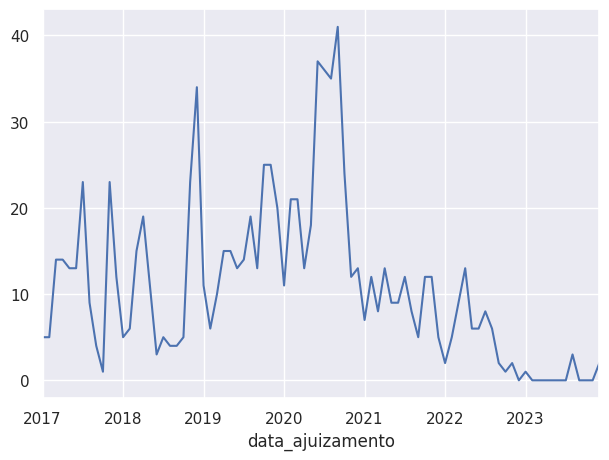

In [94]:
serie_ajuizamentos.plot()

In [ ]:
def show_tendencia(ts, rm_size):
  df_show = pd.DataFrame()

  df_show['serie'] = ts.values[rm_size:]
  df_show['rm'] = ts.rolling(rm_size).mean().values[rm_size:]

  df_show['date'] = ts.index.to_list()[rm_size:]
  df_show.set_index('date', inplace=True)
  df_show.plot()
  plt.show()

In [ ]:
show_tendencia(serie_sentencas, 12)

In [ ]:
def arima_fit_predict(ts, m, horizon, test_size):
  ts_train = ts[0:-(test_size+(horizon-1))].values
  ts_test = ts[-(test_size+(horizon-1)):].values

  model = auto_arima(ts_train, #X=None,
            start_p=2, start_q=2, max_p=5, max_d=2,
            max_q=5, start_P=1, start_Q=1, max_P=2,
            max_D=1, max_Q=2, max_order=10, m=m,
            stepwise=True, trace=True)

  direct_predict = model.predict(ts_test.shape[0])

  prevs_h_steps = []

  for t in tqdm(ts_test):
    prevs_h_steps.append(model.predict(horizon)[horizon-1])
    model.update(t)

  return prevs_h_steps[0:test_size], direct_predict[-test_size:]

In [91]:
test_size = 24
m = 12
horizon = 1
ts = serie_sentencas
prevs_h_steps, direct_predict = arima_fit_predict(ts, m, horizon, test_size)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(1,0,1)[12] intercept   : AIC=inf, Time=15.61 sec
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=352.485, Time=0.03 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=343.622, Time=2.47 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=inf, Time=3.84 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=350.664, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[12] intercept   : AIC=345.514, Time=0.07 sec
 ARIMA(1,1,0)(2,0,0)[12] intercept   : AIC=343.300, Time=7.09 sec
 ARIMA(1,1,0)(2,0,1)[12] intercept   : AIC=inf, Time=12.71 sec
 ARIMA(1,1,0)(1,0,1)[12] intercept   : AIC=344.250, Time=2.41 sec
 ARIMA(0,1,0)(2,0,0)[12] intercept   : AIC=355.382, Time=4.51 sec
 ARIMA(2,1,0)(2,0,0)[12] intercept   : AIC=341.672, Time=5.59 sec
 ARIMA(2,1,0)(1,0,0)[12] intercept   : AIC=340.007, Time=1.53 sec
 ARIMA(2,1,0)(0,0,0)[12] intercept   : AIC=338.363, Time=0.10 sec
 ARIMA(2,1,0)(0,0,1)[12] intercept   : AIC=339.915, Time=2.29 sec
 ARIMA(2,1,0)(1,0,1)[12] intercept   : AIC=

100%|██████████| 24/24 [01:14<00:00,  3.11s/it]


<Axes: xlabel='data_sentenca'>

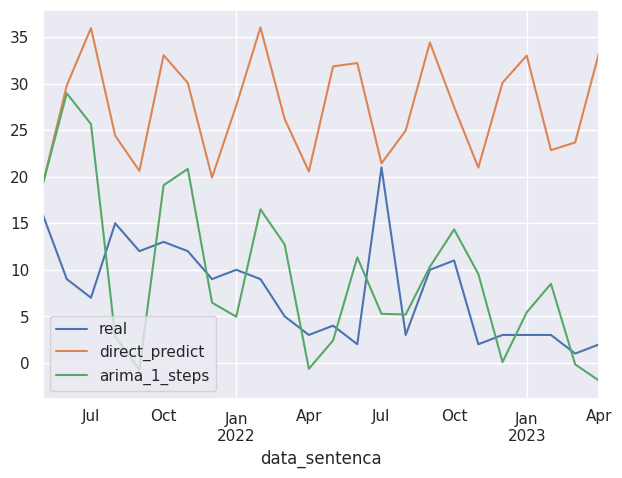

In [92]:
df_result = pd.DataFrame(
    {
        'real': ts.iloc[-test_size:],
        'direct_predict': direct_predict,
        'arima_1_steps': prevs_h_steps,
    }
)
df_result.plot()

In [93]:
kpss = KPSSTest()
print(kpss.should_diff(serie_sentencas))

(0.1, False)


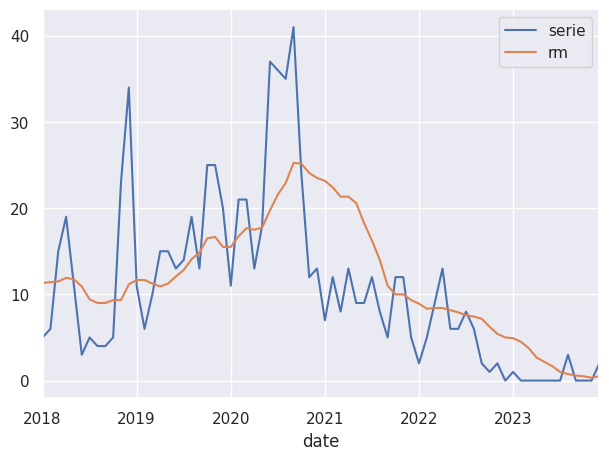

In [95]:
show_tendencia(serie_ajuizamentos, 12)

In [101]:
test_size = 24
m = 12
horizon = 1
ts = serie_ajuizamentos
prevs_h_steps, direct_predict = arima_fit_predict(ts, m, horizon, test_size)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=421.794, Time=26.05 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=438.729, Time=0.05 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=416.660, Time=6.24 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=418.844, Time=4.44 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=510.950, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=414.970, Time=0.08 sec
 ARIMA(1,0,0)(0,0,1)[12] intercept   : AIC=416.600, Time=5.75 sec
 ARIMA(1,0,0)(1,0,1)[12] intercept   : AIC=418.493, Time=8.63 sec
 ARIMA(2,0,0)(0,0,0)[12] intercept   : AIC=415.547, Time=0.14 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=414.758, Time=0.11 sec
 ARIMA(1,0,1)(1,0,0)[12] intercept   : AIC=416.623, Time=8.26 sec
 ARIMA(1,0,1)(0,0,1)[12] intercept   : AIC=416.589, Time=7.12 sec
 ARIMA(1,0,1)(1,0,1)[12] intercept   : AIC=418.456, Time=10.43 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=416.936, Time=0.23 sec
 ARIMA(2,0,1)(0,0,0)[12] interc

100%|██████████| 24/24 [00:01<00:00, 16.11it/s]


In [102]:
kpss = KPSSTest()
print(kpss.should_diff(serie_ajuizamentos))

(0.015626797282976, True)


<Axes: xlabel='data_ajuizamento'>

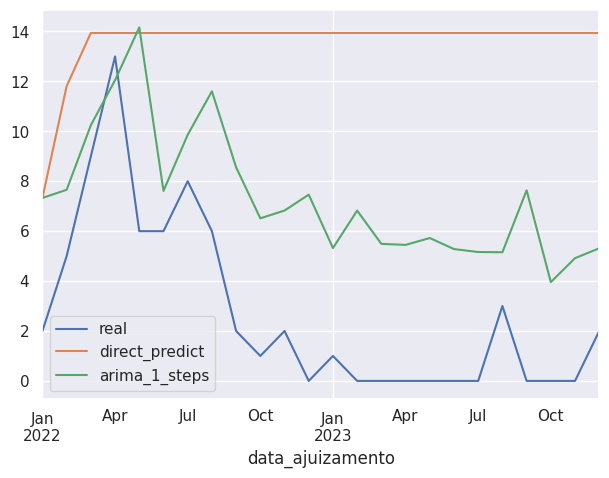

In [103]:
df_result_ajuizamento = pd.DataFrame(
    {
        'real': ts.iloc[-test_size:],
        'direct_predict': direct_predict,
        'arima_1_steps': prevs_h_steps,
    }
)
df_result_ajuizamento.plot()

In [104]:
y_true = ts.iloc[-test_size:]
metric_results = []
for model_name in ['arima_1_steps']:

  y_true = df_result_ajuizamento['real']
  y_pred = df_result_ajuizamento[model_name]
  dict_result = gerenerate_metric_results(y_true, y_pred)
  dict_result['model_name'] = model_name
  metric_results.append(dict_result)

pd.DataFrame(metric_results)

,MSE,RMSE,MAPE,MAE,theil,ARV,POCID,model_name
0,25.860233,5.085296,inf,4.667743,5.690222,0.9421,33.333333,arima_1_steps


## Testes com ML

In [ ]:
print(df_tjrn.columns)

In [ ]:
df_ml = df_sentenciados.drop(columns=['movimentos', 'numero_processo', 'data_ajuizamento', 'ultima_atualizacao', 'codigo', 'data_sentenca' ])
df_ml = pd.get_dummies(df_ml, columns=['assuntos'], drop_first=True)
df_x = df_ml.drop(columns=['tempo_ate_sentenca', 'mais60d', 'tempo_entre_3e4_mov'])
#print(df_ml.head(1))
print(df_ml.columns)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import CategoricalNB
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold

metricas = ['accuracy', 'f1', 'precision', 'recall']
rfc = RandomForestClassifier(random_state=19, n_jobs=-1)
adc = AdaBoostClassifier(random_state=19,algorithm="SAMME", n_estimators=200)
mlp = MLPClassifier(random_state=19)
dtc = DecisionTreeClassifier(random_state=19)

scores_rfc = cross_validate(rfc, df_x,
                             df_ml['mais60d'], cv=10, scoring=metricas)
scores_adc = cross_validate(adc, df_x,
                             df_ml['mais60d'], cv=10, scoring=metricas)
scores_mlp = cross_validate(mlp, df_x,
                             df_ml['mais60d'], cv=10, scoring=metricas)
scores_dtc = cross_validate(dtc, df_x,
                             df_ml['mais60d'], cv=10, scoring=metricas)

In [ ]:
chaves = scores_dtc.keys()
print(f'Usando as colunas {df_x.columns} chegou-se ao seguinte resultado\n\n')
print(f'Métrica \tRandomForest \tAdaBoost \tMLP \tDecisionTree')
for chave in chaves:
    print(f'{chave}:\t {scores_rfc[chave].mean():.3f} \t\t{scores_adc[chave].mean():.3f} \t\t{scores_mlp[chave].mean():.3f} \t\t{scores_dtc[chave].mean():.3f}')


### Modelo tentando prever se vai atrasar ou não

In [ ]:
from sklearn.tree import export_text
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_x, df_ml['mais60d'],test_size=0.20, random_state=19)

clf = DecisionTreeClassifier(max_depth=10).fit(X_train, y_train)
print(clf.score(X_test,y_test))
r = export_text(clf, feature_names=df_x.columns)

print(r)
 

### Regressão para o tempo até a sentença

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df_x, 
                                                    df_ml['tempo_ate_sentenca'], test_size=0.20, random_state=19)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error


model = RandomForestRegressor(max_depth=50, random_state=0, n_estimators=250)
model.fit(X_train, y_train)
rf_y_pred = model.predict(X_test)

rf_r2 = r2_score(y_test, rf_y_pred)
rf_mae = mean_absolute_error(y_test, rf_y_pred)
rf_rmse = mean_squared_error(y_test, rf_y_pred, squared=False)
rf_mse = mean_squared_error(y_test, rf_y_pred)

print('----------------------------------------------------')

print(f'AdaBoost Regressor')
regr = AdaBoostRegressor(random_state=0, n_estimators=100)
regr.fit(X_train, y_train)
ada_y_pred = regr.predict(X_test)

ada_r2 = r2_score(y_test, ada_y_pred)
ada_mae = mean_absolute_error(y_test, ada_y_pred)
ada_rmse = mean_squared_error(y_test, ada_y_pred, squared=False)
ada_mse = mean_squared_error(y_test, ada_y_pred)

print('----------------------------------------------------')

print(f'MLP Regressor')

regr_mlp = MLPRegressor(random_state=1, max_iter=500).fit(X_train, y_train)
mlp_y_pred = regr_mlp.predict(X_test)

mlp_r2 = r2_score(y_test, mlp_y_pred)
mlp_mae = mean_absolute_error(y_test, mlp_y_pred)
mlp_rmse = mean_squared_error(y_test, mlp_y_pred, squared=False)
mlp_mse = mean_squared_error(y_test, mlp_y_pred)

print('----------------------------------------------------')

print(f'DT Regressor')
regressor = DecisionTreeRegressor(random_state=0).fit(X_train, y_train)
dt_y_pred = regr_mlp.predict(X_test)

dt_r2 = r2_score(y_test, dt_y_pred)
dt_mae = mean_absolute_error(y_test, dt_y_pred)
dt_rmse = mean_squared_error(y_test, dt_y_pred, squared=False)
dt_mse = mean_squared_error(y_test, dt_y_pred)

print(f'Metric\t\t\t\t RF\t AdaBoost\t MLP\t\t DT')
print(f"Mean Squared Error:\t\t {rf_r2:.3f}\t {ada_r2:.3f}\t\t {mlp_r2:.3f}\t\t {dt_r2:.3f}")
print(f"R-squared (R²):\t\t\t {rf_mae:.3f}\t {ada_mae:.3f}\t {mlp_mae:.3f}\t\t {dt_mae:.3f}")
print(f"Mean Absolute Error (MAE):\t {rf_mae:.3f}\t {ada_rmse:.3f}\t {mlp_rmse:.3f}\t {dt_rmse:.3f}")
print(f"Root Mean Squared Error (RMSE):\t {rf_rmse:.3f} {ada_mse:.3f}\t {mlp_mse:.3f}\t {dt_mse:.3f}")

In [ ]:
""" from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RepeatedStratifiedKFold

cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=3, random_state=19)
rfc = RandomForestRegressor()

param_grid = [{'n_estimators': [100, 300, 500],
               'min_samples_split': [2, 5, 25],
               'min_samples_leaf': [3, 4, 5, 20],
               'max_depth': [5, 35, 50]}]

clf = GridSearchCV(rfc, param_grid = param_grid, n_jobs=-1, scoring='roc_auc', verbose=1)

clf.fit(X_train, y_train)
best_model = clf.best_estimator_ """

In [ ]:
""" results_df = pd.DataFrame(clf.cv_results_)

results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))
).rename_axis("kernel")
#print(results_df.columns)
results_df = results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]]

print(results_df.head(3)) """